# 0. Instructions and setup

## 0.1. Instructions. Part 2: Data Scientist Challenge (3.5 points)

- **Objective:** Explore different techniques to enhance model performance with limited  labeled data. You will be limited to 32 labeled examples in your task.  The rest can be viewed as unlabelled data. 

- **Tasks:**
  - **a. BERT Model with Limited Data (0.5 points):** Train a BERT-based model using only 32 labeled examples and assess its performance.
  - **b. Dataset Augmentation (1 point):** Experiment with an automated technique to increase your dataset size **without using LLMs** (chatGPT / Mistral / Gemini / etc...). Evaluate the impact on model performance.
  - **c. Zero-Shot Learning with LLM (0.5 points):** Apply a LLM (chatGPT/Claude/Mistral/Gemini/...) in a zero-shot learning setup. Document the performance.
  - **d. Data Generation with LLM (1 point):** Use a LLM (chatGPT/Claude/Mistral/Gemini/...) to generate new, labeled  dataset points. Train your BERT model with it + the 32 labels. Analyze  how this impacts model metrics.
  - **e. Optimal Technique Application (0.5 points):** Based on the previous experiments, apply the most effective  technique(s) to further improve your model's performance. Comment your results and propose improvements.

## 0.2. Libraries

In [1]:
# # !pip install polars  # Install polars for faster data processing

In [8]:
# Utilities
import numpy as np
import polars as pl
from library.metrics import Metrics, evaluate_classification
from library.utilities import set_seed, sample_balanced_dataset
from datasets import Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import os
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import time

# Deep Learning and NLP
import torch
import setfit
from transformers import (AutoTokenizer, AutoModel,
                          AutoModelForSequenceClassification,
                          TrainingArguments, Trainer,
                          EarlyStoppingCallback)
from library.setfit import run_setfit_training, evaluate_setfit_on_test
from library.fine_tuning import evaluate_best_finetuned_model
from library.metrics import Metrics
from library.utilities import set_seed

metrics = Metrics()

In [2]:
# Check the availability of a GPU
print(torch.cuda.is_available())

True


## 0.3. Random Seed

In [17]:
# Set random seed for reproducibility
seed = 42
set_seed(42)

Seed set to 42. This ensures reproducibility of results across runs.


## 0.4. Loading the data: Swiss Judgement Prediction

Source: https://huggingface.co/datasets/rcds/swiss_judgment_prediction

In [12]:
# Load the cleaned Parquet file
df = pl.read_parquet('data\FRENCH_swiss_judgment_prediction_combined.parquet')

# Display the loaded DataFrame
print("\nLoaded DataFrame shape:", df.shape)
print("\nLoaded DataFrame schema:")
print(df.schema)
print("\nFirst few rows of the loaded DataFrame:")
df.head()

<>:2: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\F'
C:\Users\matia\AppData\Local\Temp\ipykernel_19512\1903425062.py:2: SyntaxWarning: invalid escape sequence '\F'
  df = pl.read_parquet('data\FRENCH_swiss_judgment_prediction_combined.parquet')



Loaded DataFrame shape: (31094, 9)

Loaded DataFrame schema:
Schema({'id': Int32, 'year': Int32, 'text': String, 'labels': Int64, 'language': String, 'region': String, 'canton': String, 'legal area': String, 'split': String})

First few rows of the loaded DataFrame:


id,year,text,labels,language,region,canton,legal area,split
i32,i32,str,i64,str,str,str,str,str
0,2000,"""A.- Par contrat d'entreprise s…",0,"""fr""",null,null,"""civil law""","""train"""
1,2000,"""A.- Le 12 avril 1995, A._ a su…",0,"""fr""",null,null,"""insurance law""","""train"""
2,2000,"""A.- En février 1994, M._ a été…",0,"""fr""","""Région lémanique""","""ge""","""insurance law""","""train"""
3,2000,"""A.- M._ a travaillé en qualité…",0,"""fr""",null,null,"""insurance law""","""train"""
6,2000,"""A.- Le 29 septembre 1997, X._ …",0,"""fr""","""Espace Mittelland""","""ne""","""penal law""","""train"""


In [13]:
# Split the DataFrame into training, validation and test sets
train_df = df.filter(pl.col('split') == 'train')
val_df = df.filter(pl.col('split') == 'validation')
test_df = df.filter(pl.col('split') == 'test')

# Delete the original data to free up memory
del df

# 1. BERT Model with Limited Data

Outline of the intermediate tasks:

1. Preprocessing Pipeline
   - Lowercasing, punctuation stripping (or not, depending on BERT tokenizer).
   - Sentencepiece/BPE tokenization via the CamemBERT (for French) or UmBERTo (for Italian).
   - (Optional) language tags if you merge FR+IT in one model.
2. Hold-out Split. Since you only have 32 labels: use stratified k-fold CV (e.g. 8 × 4-fold) to get reliable estimates, or leave-one-out if you want maximum training data per fold.
3. BERT Model with Only 32 Examples
   - Model Choice: Pick a multilingual BERT (mBERT) or separate CamemBERT/UmBERTo checkpoint. Alternatives:
     - Multilingual/monolingual models:
       - One multilingual [`Sentence-Transformer` model](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models), such as `paraphrase-multilingual-mpnet-base-v2` (best multilingual performer), `paraphrase-multilingual-MiniLM-L12-v2` (similar performer as the former, but much faster and smaller) or `distiluse-base-multilingual-cased-v1` (worst of the bunch).
       -  [BERT multilingual base model (cased)](https://huggingface.co/google-bert/bert-base-multilingual-cased). [Uncased model](https://huggingface.co/google-bert/bert-base-multilingual-uncased) also available. For an even smaller model, the distilled version can be used: [`distilbert-base-multilingual-cased`](https://huggingface.co/distilbert/distilbert-base-multilingual-cased).
       -  [CamemBERT 2.0](https://huggingface.co/almanach/camembertv2-base) and [CamemBERTav2](https://huggingface.co/almanach/camembertav2-base), models trained with French text and explained in the paper: [CamemBERT 2.0: A Smarter French Language Model Aged to Perfection](https://arxiv.org/html/2411.08868v1#S3). These models supposedly improve over the performance of the original [CamemBERT](https://huggingface.co/almanach/camembert-base) model, explained in "[CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894)".
       -  [FlauBERT](https://huggingface.co/docs/transformers/en/model_doc/flaubert), another model pre-trained on French text. Paper: "[FlauBERT: Unsupervised Language Model Pre-training for French](https://arxiv.org/abs/1912.05372)". 
       -  [BERT Base Italian Cased](https://huggingface.co/dbmdz/bert-base-italian-cased), [Uncased](https://huggingface.co/dbmdz/bert-base-italian-uncased), ,and [XXL Uncased](https://huggingface.co/dbmdz/bert-base-italian-xxl-uncased). 
       -  [UmBERTo Commoncrawl Cased](https://huggingface.co/Musixmatch/umberto-commoncrawl-cased-v1), another model trained with a large corpus of texts in Italian.
      -  Domain-specific models (law):
          - [LEGAL-BERT](https://huggingface.co/nlpaueb/legal-bert-base-uncased) does not seem to be a good option as it was trained only on English data.
          - [JuriBERT](https://huggingface.co/dascim/juribert-base) for legal texts in French. Paper explaining the model: [JuriBERT: A Masked-Language Model Adaptation for French Legal Text](https://arxiv.org/pdf/2110.01485).
          - [ITALIAN-LEGAL-BERT](https://huggingface.co/dlicari/Italian-Legal-BERT) for legal text in Italian. Paper explaining the model: [ITALIAN-LEGAL-BERT models for improving natural language processing tasks in the Italian legal domain](https://www.sciencedirect.com/science/article/pii/S0267364923001188).
     - Models to try: 
       - For both languages: `paraphrase-multilingual-MiniLM-L12-v2` (of the SentenceTransformers, good balance between performance and speed), BERT multilingual base model (cased).
       - For French: CamemBERT, FlauBERT, CamemBERTav2 (based on DebertaV2 architecture), JuriBERT.
       - For Italian: BERT Base Italian Cased, UmBERTo Commoncrawl Cased, ITALIAN-LEGAL-BERT.
     - [Model memory estimator](https://huggingface.co/docs/accelerate/en/usage_guides/model_size_estimator): in order to know whether a model actually fits in the memory of your computer.
   - Fine-tuning Setup.
     - Freeze or unfreeze last n encoder layers—try both.
     - Small learning rate (2e-5 – 5e-5), batch size = 8 or 16.
     - Early stopping on validation loss.
4. Training & Evaluation
    - Run your k-fold CV training loops.
    - Track accuracy, F1, precision, recall per fold.
    - Report mean ± std.
5. Error Analysis and feature interpretation.
    - Use `LIME` for analyzing the most relevant features for classifying the texts. 
    - Look at which examples are mispredicted.
    - Check language breakdown (FR vs. IT) to see if one is harder.

## 1.1. Using SetFit ("Sentence Transformer Fine-Tuning")

Notebook of reference: `Session_6_2_Zero_Shot_Classification.ipynb`, introduction, step 1 (loading data) and step 6 ("Few-Shot Classification with SetFit").

Applying SetFit (the “Sentence Transformer Fine-Tuning” recipe) can be regarded as **training** (it fine-tunes a pre-trained sentence-embedding model, plus fits a small classifier on top). Furthermore, SetFit was built **for** getting strong performance with as few as a few dozen labeled examples.

---

**Why SetFit can be regarded as training**

- **Contrastive fine-tuning:**
  We start with a frozen (or lightly unfrozen) Sentence-Transformer model and then *fine-tune* it on automatically generated sentence pairs derived from your 32 labels.
- **Classifier head training:**
  After contrastive tuning, SetFit fits a lightweight logistic-regression (or small MLP) classifier on the resulting embeddings.
- Both steps update model parameters—so it’s training/fine-tuning, not mere prompt-engineering or zero-shot.

---

**Why SetFit excels in limited-label regimes**

1. **Data amplification via contrastive pairs**

   - From each labeled example, SetFit creates positive pairs (e.g. two different augmentations of the same sentence) and negative pairs (across classes), turning 32 labels into hundreds or thousands of pairwise signals.
   - That extra signal helps the embedding space separate classes, even when you only have a few “gold” labels.

1. **Lightweight classifier**

   * Because the embedding model has already been tuned to distinguish the classes, the final classifier can be a simple logistic or MLP—so it needs very few examples to learn decision boundaries.

2. **Empirical few-shot strength**

   * In benchmarks, SetFit often outperforms standard BERT fine-tuning with few labels, and it’s much faster to train (no full back-prop through all BERT layers).

---

Note that there are 2 aspects that we need to implement for SetFit to work properly:

1. **Balance the examples of positive and negative classes** that will be passed for contrastive learning. Since approximately 29% of the labels are positive (approved motions) and the other 71% correspond to rejected motions, passing examples for contrastive learning without balancing the clases would bias the embedding space towards the majority class.
   
2. We need to **run several iterations** in order to get lower variability in the results, as a single training run can be highly variable due to randomness in the example sampling (as we only pass 32 labelled examples). Therefore, if we don't run several iterations for SetFit, the results would be highly noisy. Averaging across iterations smooths out this variance and gives us the true expected performance.

Note that SetFit only natively supports sentence-transformer models: passing one which is [not](https://huggingface.co/models?library=sentence-transformers&author=sentence-transformers) (see also the [docs](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models)) will make SetFit automatically wrap the BERT model with a sentence-transformers layer using mean pooling. Using a model that is not part of the `sentence-transformers` will yield the following message:

> No sentence-transformers model found with name google-bert/bert-base-multilingual-cased. Creating a new one with mean pooling.

However, for better performance with SetFit, it is preferred to use a model that was specifically pre-trained as a sentence transformer.

   - Model Choice: Pick a multilingual BERT (mBERT) or separate CamemBERT/UmBERTo checkpoint. Alternatives:
     - Multilingual/monolingual models:
       - One multilingual [`Sentence-Transformer` model](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models), such as `paraphrase-multilingual-mpnet-base-v2` (best multilingual performer), `paraphrase-multilingual-MiniLM-L12-v2` (similar performer as the former, but much faster and smaller) or `distiluse-base-multilingual-cased-v1` (worst of the bunch).
       -  [BERT multilingual base model (cased)](https://huggingface.co/google-bert/bert-base-multilingual-cased). [Uncased model](https://huggingface.co/google-bert/bert-base-multilingual-uncased) also available. Paper: "[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)". 
       -  [CamemBERT 2.0](https://huggingface.co/almanach/camembertv2-base) and [CamemBERTav2](https://huggingface.co/almanach/camembertav2-base), models trained with French text and explained in the paper: [CamemBERT 2.0: A Smarter French Language Model Aged to Perfection](https://arxiv.org/html/2411.08868v1#S3). These models supposedly improve over the performance of the original [CamemBERT](https://huggingface.co/docs/transformers/en/model_doc/camembert) model, explained in "[CamemBERT: a Tasty French Language Model](https://arxiv.org/abs/1911.03894)".
       -  [FlauBERT](https://huggingface.co/docs/transformers/en/model_doc/flaubert), another model pre-trained on French text. Paper: "[FlauBERT: Unsupervised Language Model Pre-training for French](https://arxiv.org/abs/1912.05372)". 
       -  [BERT Base Italian Cased](https://huggingface.co/dbmdz/bert-base-italian-cased), [Uncased](https://huggingface.co/dbmdz/bert-base-italian-uncased), ,and [XXL Uncased](https://huggingface.co/dbmdz/bert-base-italian-xxl-uncased). 
       -  [UmBERTo Commoncrawl Cased](https://huggingface.co/Musixmatch/umberto-commoncrawl-cased-v1), another model trained with a large corpus of texts in Italian.
      -  Domain-specific models (law):
          - [LEGAL-BERT](https://huggingface.co/nlpaueb/legal-bert-base-uncased) does not seem to be a good option as it was trained only on English data.
          - [JuriBERT](https://huggingface.co/dascim/juribert-base) for legal texts in French. Paper explaining the model: [JuriBERT: A Masked-Language Model Adaptation for French Legal Text](https://arxiv.org/pdf/2110.01485).
          - [ITALIAN-LEGAL-BERT](https://huggingface.co/dlicari/Italian-Legal-BERT) for legal text in Italian. Paper explaining the model: [ITALIAN-LEGAL-BERT models for improving natural language processing tasks in the Italian legal domain](https://www.sciencedirect.com/science/article/pii/S0267364923001188).

Models to try: 
- For both languages: `paraphrase-multilingual-MiniLM-L12-v2` (of the SentenceTransformers, good balance between performance and speed), distilled BERT multilingual base model (cased) ([`distilbert-base-multilingual-cased`](https://huggingface.co/distilbert/distilbert-base-multilingual-cased).)
- For French: CamemBERTav2 (based on DebertaV2 architecture), JuriBERT.
- For Italian: BERT Base Italian Cased, ITALIAN-LEGAL-BERT.

[Model memory estimator](https://huggingface.co/docs/accelerate/en/usage_guides/model_size_estimator): in order to know whether a model actually fits in the memory of your computer:



Finally, consider that there might be some memory issues by running SetFit:  ( https://github.com/huggingface/setfit/issues/472 ). Adapt the hyperparameters consequently to your memory limitations.

### Multilingual models

#### `paraphrase-multilingual-MiniLM-L12-v2`

In [9]:
# Rename columns to match SetFit requirements (labels should be 'labels'), creating a copy
train_df_setfit = train_df.clone()
val_df_setfit = val_df.clone()
train_df_setfit = train_df_setfit.rename({'labels': 'label'})
val_df_setfit = val_df_setfit.rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 10  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"  # Path to the pre-trained model
batch_size = 64 # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_setfit = val_df_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

results_m1 = run_setfit_training(
    train_df=train_df_setfit, 
    val_df=val_df_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)


Iteration 1/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.242800


Training completed.
Validation F1: 0.2857
New best model found with f1: 0.2857

Iteration 2/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.287600


Training completed.
Validation F1: 0.2508

Iteration 3/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.293600


Training completed.
Validation F1: 0.2566

Iteration 4/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.305100


Training completed.
Validation F1: 0.2593

Iteration 5/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.256500


Training completed.
Validation F1: 0.3069
New best model found with f1: 0.3069

Iteration 6/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.269200


Training completed.
Validation F1: 0.2338

Iteration 7/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.259300


Training completed.
Validation F1: 0.2830

Iteration 8/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.282000


Training completed.
Validation F1: 0.2618

Iteration 9/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.259300


Training completed.
Validation F1: 0.2837

Iteration 10/10


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

***** Running training *****
  Num unique pairs = 544
  Batch size = 64
  Num epochs = 5


Step,Training Loss
1,0.259700


Training completed.
Validation F1: 0.2279
Finished training in all iterations. Saving the results to a parquet file...
Best model saved to: models/part_2/a/setfit_best_paraphrase-multilingual-MiniLM-L12-v2
Results saved to: results/part_2/a/setfit_results_paraphrase-multilingual-MiniLM-L12-v2.parquet


In [10]:
model_name = 'paraphrase-multilingual-MiniLM-L12-v2'

results_m1 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m1)

# Print mean of all metrics across iterations
metrics = ['accuracy', 'f1', 'precision', 'recall']
mean_metrics = results_m1.select([pl.col(metric).mean().alias(metric) for metric in metrics]).to_dict(as_series=False)
print("\nMean metrics across all iterations:")
print(mean_metrics)

Results for model: paraphrase-multilingual-MiniLM-L12-v2


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.55,0.285714,0.204545,0.473684,1
0.546,0.250825,0.182692,0.4,2
0.49,0.25656,0.177419,0.463158,3
0.52,0.259259,0.183406,0.442105,4
0.458,0.306905,0.202703,0.631579,5
0.502,0.233846,0.165217,0.4,6
0.544,0.283019,0.201794,0.473684,7
0.436,0.26178,0.174216,0.526316,8
0.384,0.283721,0.18209,0.642105,9



Mean metrics across all iterations:
{'accuracy': [0.5010000000000001], 'f1': [0.26495709982755045], 'precision': [0.1849223869644958], 'recall': [0.47789473684210526]}


#### BERT-base multilingual cased

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'labels'), creating a copy
train_df_setfit = train_df.clone()
val_df_setfit = val_df.clone()
train_df_setfit = train_df_setfit.rename({'labels': 'label'})
val_df_setfit = val_df_setfit.rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "google-bert/bert-base-multilingual-cased"  # Path to the pre-trained model
batch_size = 8 # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_df_setfit = val_df_setfit.sample(n=sample_size_val, shuffle=True, seed=seed)

results_m2 = run_setfit_training(
    train_df=train_df_setfit, 
    val_df=val_df_setfit, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)

In [ ]:
model_name = 'bert-base-multilingual-cased'

results_m2 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m2)

# Print mean of all metrics across iterations
metrics = ['accuracy', 'f1', 'precision', 'recall']
mean_metrics = results_m2.select([pl.col(metric).mean().alias(metric) for metric in metrics]).to_dict(as_series=False)
print("\nMean metrics across all iterations:")
print(mean_metrics)

Results for model: google-bert/bert-base-multilingual-cased


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.532,0.26875,0.191111,0.452632,1
0.42,0.299517,0.194357,0.652632,2
0.61,0.229249,0.183544,0.305263,3
0.464,0.298429,0.198606,0.6,4
0.496,0.296089,0.201521,0.557895,5


Considering that the performance with these multilingual models is worse than random, we will focus on improving performance for the texts (only) in French. Since the number of observations for the cases in Italian is low, we will not try to improve performance for that subset. 

### Models pre-trained in French

#### CamemBERT

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'labels'), creating a copy
train_fr_df = train_df.clone()
val_fr_df = val_df.clone()
# Keep only the columns where the language is French
train_fr_df = train_fr_df.filter(pl.col('language') == 'fr').rename({'labels': 'label'})
val_fr_df = val_fr_df.filter(pl.col('language') == 'fr').rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "almanach/camembert-base"  # Path to the pre-trained model
batch_size = 8  # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_fr_df = val_fr_df.sample(n=sample_size_val, shuffle=True, seed=seed)

results_m3 = run_setfit_training(
    train_df=train_fr_df, 
    val_df=val_fr_df, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)

In [26]:
model_name = 'camembert-base'

results_m3 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m3)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_m3.filter(pl.col('f1') == results_m3['f1'].max())
print("\nBest iteration metrics (highest F1-score):")
display(best_epoch)

Results for model: camembert-base


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.642,0.286853,0.25,0.336449,1
0.644,0.245763,0.224806,0.271028,2
0.446,0.31941,0.216667,0.607477,3
0.46,0.341463,0.231023,0.654206,4
0.628,0.243902,0.215827,0.280374,5



Best iteration metrics (highest F1-score):


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.46,0.341463,0.231023,0.654206,4


#### JuriBERT-base

In [ ]:
# Rename columns to match SetFit requirements (labels should be 'labels'), creating a copy
train_fr_df = train_df.clone()
val_fr_df = val_df.clone()
# Keep only the columns where the language is French
train_fr_df = train_fr_df.filter(pl.col('language') == 'fr').rename({'labels': 'label'})
val_fr_df = val_fr_df.filter(pl.col('language') == 'fr').rename({'labels': 'label'})

# Define sample size (labelled examples for training)
sample_size = 32
num_iterations = 5  # Run several iterations for the sample size (32 labels) to minimize the impact of randomness
metric = 'f1'  # Metric to optimize
model_name = "dascim/juribert-base"  # Path to the pre-trained model
batch_size = 8  # Batch size for training (reduce if you run into memory issues, but larger batch sizes will speed up training)
num_epochs = 5  # Number of epochs for training
learning_rate= 2e-5  # Learning rate for the optimizer

# Create a subset of the validation data frame for faster processing
sample_size_val = 500
val_fr_df = val_fr_df.sample(n=sample_size_val, shuffle=True, seed=seed)

results_m4 = run_setfit_training(
    train_df=train_fr_df, 
    val_df=val_fr_df, 
    model_name=model_name, 
    num_epochs=num_epochs, 
    batch_size=batch_size, 
    learning_rate=learning_rate, 
    sample_size=sample_size, 
    metric=metric, 
    num_iterations=num_iterations, 
    seed=seed
)

In [25]:
model_name = 'juribert-base'

results_m4 = pl.read_parquet(os.path.join('results', 'part_2', 'a', f'setfit_results_{model_name}.parquet'))

print(f'Results for model: {model_name}')
display(results_m4)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_m4.filter(pl.col('f1') == results_m4['f1'].max())
print("\nBest iteration metrics (highest F1-score):")
display(best_epoch)

Results for model: juribert-base


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.606,0.318339,0.252747,0.429907,1
0.418,0.285012,0.193333,0.542056,2
0.522,0.307246,0.222689,0.495327,3
0.578,0.259649,0.207865,0.345794,4
0.574,0.292359,0.226804,0.411215,5



Best iteration metrics (highest F1-score):


accuracy,f1,precision,recall,iteration
f64,f64,f64,f64,i64
0.606,0.318339,0.252747,0.429907,1


## 1.2. Standard fine-tuning

Notebook of reference: `Session_5_1_BERT_HF_Implementation.ipynb`, sections 1, 2 and 5.

### With CamemBERT

First, we set basic parameters that we will need for fine-tuning a model based on the BERT architecture.

In [9]:
model_name = "almanach/camembert-base"  # Path to the pre-trained model
num_labels = 2  # Number of labels for the classification task (in this case, binary classification)
max_length = min(int(AutoModel.from_pretrained(model_name).config.max_position_embeddings), 512)  # Maximum length of the input sequences (truncation if larger than this). Set dynamically based on the chosen model.

print(f"Model: {model_name}, Max Length: {max_length}")

Model: almanach/camembert-base, Max Length: 512


Second, we tokenize the text and create the vocabulary IDs in order to create the inputs for the BERT-based model.

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [11]:
sample_text = train_df.select('text')['text'][0]  # Select the text of the first sample

# Tokenize the sample text considering the maximum length
tokens = tokenizer(
    sample_text, 
    max_length=max_length,  # Truncate to the maximum length of the model 
    truncation=True, 
    padding='max_length'  # Pad to the maximum length
)

# Display input IDs (tokenized & padded)
print(f"Sample text: {sample_text}")
print("Token IDs:", tokens["input_ids"])
print("Length:", len(tokens["input_ids"]))
print("Attention Mask:", tokens["attention_mask"])

Sample text: Faits: A. Le 28 octobre 2002 à 14 h.50, A._, domiciliée en France, circulait, au volant d'une voiture dont elle est détentrice, sur la route d'Hermance (GE) en direction de Corsier, après avoir quitté une place de stationnement. Alors qu'elle obliquait à gauche pour entrer dans le parking de la poste de Collonge-Bellerive en vue d'effectuer un demi-tour, l'arrière gauche de sa voiture a été heurté par un scooter de marque Honda Fes piloté par son détenteur, B._. Ce dernier a été grièvement blessé. Au lieu de l'accident, la vitesse maximale autorisée était de 50 km/h. A l'endroit où l'automobiliste a obliqué à gauche - manoeuvre qui était permise -, la ligne centrale est pointillée, alors qu'elle est pleine avant et après cet endroit. Le scooter a laissé une trace de freinage de 9,7 mètres qui commence sur la ligne de sécurité et évolue vers la gauche. La conductrice de la voiture a reconnu qu'elle n'avait pas regardé derrière elle avant d'obliquer. La police a infligé une 

In [12]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_length)

# We convert the Polars Data Frame to an arrow Dataset and get a sample of the training data
if 'labels' in train_df_fr.columns:
    train_df_fr = train_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with sampling function
train_set_fr = sample_balanced_dataset(train_df_fr, 32, seed)
train_set_fr = train_set_fr.rename_column('label', 'labels')  # Rename the label column again to 'labels' for compatibility with Hugging Face Trainer
# train_set_fr = Dataset.from_polars(train_df_fr.select(['text', 'labels']).sample(n=32, shuffle=True, seed=seed))
val_set_fr = Dataset.from_polars(val_df_fr.select(['text', 'labels']))

# Now, we actually tokenize the datasets
train_set_fr = train_set_fr.map(tokenize, batched=True, remove_columns=["text"])
val_set_fr = val_set_fr.map(tokenize, batched=True, remove_columns=["text"])

# Convert the data in the datasets to PyTorch tensors
train_set_fr.set_format(type='torch')
val_set_fr.set_format(type='torch')

# Display the first example from the training set
print("\nFirst example from the training set:")
print(train_set_fr[0])

/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]


First example from the training set:
{'labels': tensor(1), 'input_ids': tensor([    5,  9447,    10,    43,  9447,    10,    43,   114,     9,   502,
          124,   108,   732,  7416,    36,   181,   667,  9474,   275,     9,
          862,    33, 11125,    20, 19377,     8,  4103,    31,   111,    96,
          101, 20796,    37,    13, 12088,     8,  4103,    25,  8259, 12254,
          537,  2143,   156,  9311,    38,   244,    26,   856,    92,    13,
         5454,     8,  4103,    53,    42,   340,  5981,  9637,    36,   205,
          667,  7416,     9,    54,   409,   652,  5985,     7,    51,   171,
         7145,    28,   400,     8,  2734,   843,     8,    17,    11,  8321,
        27333,     8,    17,    11,  2049,    26, 21556,    38,   244,    26,
          856,    92,    17,    11,  7720,    21,  7771,   120,   211,    23,
          327,     8,  1141,    25,  1157,   732,  9474,  4109,   666,    29,
           28,  1141,    25,   135,   871, 10801,    17,    11,  7720

The transformation has been executed as expected: we now have all of the features (input IDs) and labels saved as tensors. Remember that the attention mask explicits which tokens are actually real (1) and which are padded (0). 

Third, we initialize the `AutoModelForSequenceClassification` class from Hugging Face, which automatically handles the creation of a classification layer on top of the embedding layers of the BERT-based model. 

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at almanach/camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fourth, we configure the relevant training arguments.

In [14]:
san_model_name = model_name.split(sep='/')[-1]  # Sanitize model name for file path, keep only the last part

train_args = TrainingArguments(
    output_dir = os.path.join('models', 'part_2', 'a', f'cls_fine_tuning_{san_model_name}'),
    eval_strategy = "epoch",  # Evaluate at the end of each epoch
    save_strategy = "epoch",  # Save the model at the end of each epoch
    logging_strategy = "steps",  # Log training progress every logging_steps
    logging_steps = 50,
    learning_rate = 2e-5,  # Learning rate for fine-tuning the language model
    per_device_train_batch_size = 16,  # Batch size for training
    per_device_eval_batch_size  = 16,  # Batch size for evaluation
    num_train_epochs = 20,  # Maximum number of epochs for training (unless early stopping is triggered)
    weight_decay = 0.01,  # Weight decay for regularization
    load_best_model_at_end = True,  # Load the best model at the end of training based on evaluation loss
    metric_for_best_model = "eval_loss",  # Metric to use for determining the best model
    save_total_limit = 2,  # Limit the total number of saved models to the best 2 models
    seed = seed,  # Set random seed for reproducibility
    report_to = "none",  # Disable wandb
    fp16 = True, # Enables mixed precision training (compatible on some GPUs, but not all). Set to True if you have a compatible GPU.
    gradient_accumulation_steps = 2  # Gradient accumulation steps to effectively increase the batch size without increasing memory usage
)

print("Output directory for the model:", train_args.output_dir)

Output directory for the model: models/part_2/a/cls_fine_tuning_camembert-base


Finally, we initialize the `Trainer` class, fine-tune the embedding model and train the classifier.

In [ ]:
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_set_fr,
    eval_dataset=val_set_fr.shuffle(seed=seed),  # Shuffle the validation set for evaluation
    compute_metrics=lambda p: {  # Return a dictionary of metrics
        "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),  # Compare the true labels with the predicted labels, by selecting the index with the highest probability
        "f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "precision": precision_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "recall": recall_score(p.label_ids, np.argmax(p.predictions, axis=1))
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # Early stopping after 3 epochs without improvement
)

train_output = trainer.train()

# Filter for epoch logs (those that have 'epoch' key)
log_history = trainer.state.log_history
epoch_logs = [log for log in log_history if 'epoch' in log]

# Convert to Polars DataFrame
results_df = pl.DataFrame(epoch_logs)

# Save results in a Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_{san_model_name}.parquet')
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists
results_df.write_parquet(results_path)
print(f'Results saved to: {results_path}')

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.697425,0.276575,0.339333,0.209854,0.885978
2,No log,0.696253,0.335703,0.332901,0.210851,0.790447
3,No log,0.698141,0.267528,0.341563,0.210451,0.906009
4,No log,0.698896,0.256866,0.340218,0.209024,0.913713
5,No log,0.697306,0.338934,0.336576,0.213142,0.799692
6,No log,0.694188,0.490792,0.306948,0.214769,0.537750
7,No log,0.690351,0.621002,0.262728,0.221868,0.322034
8,No log,0.688712,0.649435,0.252240,0.228180,0.281972
9,No log,0.687847,0.655574,0.242898,0.225296,0.263482
10,No log,0.686955,0.660420,0.240058,0.226158,0.255778


In [18]:
# Load the results DataFrame from the Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_camembert-base.parquet')
results_df = pl.read_parquet(results_path)

# Display the metrics DataFrame
print("\nMetrics DataFrame:")
display(results_df)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_df.filter(pl.col('eval_loss') == results_df['eval_loss'].min()).select(['epoch', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall'])
print("\nBest epoch metrics (lowest validation loss):")
display(best_epoch)


Metrics DataFrame:


eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64
0.697425,0.276575,0.339333,0.209854,0.885978,17.2477,179.444,11.248,1.0,1,null,null,null,null,null
0.696253,0.335703,0.332901,0.210851,0.790447,17.599,175.862,11.023,2.0,2,null,null,null,null,null
0.698141,0.267528,0.341563,0.210451,0.906009,17.7029,174.83,10.959,3.0,3,null,null,null,null,null
0.698896,0.256866,0.340218,0.209024,0.913713,17.64,175.454,10.998,4.0,4,null,null,null,null,null
0.697306,0.338934,0.336576,0.213142,0.799692,17.6216,175.637,11.009,5.0,5,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0.688309,0.634895,0.267185,0.230683,0.317411,17.5951,175.901,11.026,12.0,12,null,null,null,null,null
0.689218,0.617447,0.279805,0.231156,0.354391,17.6085,175.767,11.017,13.0,13,null,null,null,null,null
0.689515,0.607108,0.282172,0.228708,0.368259,17.6307,175.547,11.004,14.0,14,null,null,null,null,null



Best epoch metrics (lowest validation loss):


epoch,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall
f64,f64,f64,f64,f64,f64
10.0,0.686955,0.66042,0.240058,0.226158,0.255778


### With JuriBERT-base

In [13]:
model_name = "dascim/juribert-base"  # Path to the pre-trained model
num_labels = 2  # Number of labels for the classification task (in this case, binary classification)
max_length = min(int(AutoModel.from_pretrained(model_name).config.max_position_embeddings), 512)  # Maximum length of the input sequences (truncation if larger than this). Set dynamically based on the chosen model.

print(f"Model: {model_name}, Max Length: {max_length}")

Some weights of BertModel were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: dascim/juribert-base, Max Length: 512


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=max_length)

# We convert the Polars Data Frame to an arrow Dataset and get a sample of the training data
if 'labels' in train_df_fr.columns:
    train_df_fr = train_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with sampling function
train_set_fr = sample_balanced_dataset(train_df_fr, 32, seed)
train_set_fr = train_set_fr.rename_column('label', 'labels')  # Rename the label column again to 'labels' for compatibility with Hugging Face Trainer
# train_set_fr = Dataset.from_polars(train_df_fr.select(['text', 'labels']).sample(n=32, shuffle=True, seed=seed))
val_set_fr = Dataset.from_polars(val_df_fr.select(['text', 'labels']))

# Now, we actually tokenize the datasets
train_set_fr = train_set_fr.map(tokenize, batched=True, remove_columns=["text"])
val_set_fr = val_set_fr.map(tokenize, batched=True, remove_columns=["text"])

# Convert the data in the datasets to PyTorch tensors
train_set_fr.set_format(type='torch')
val_set_fr.set_format(type='torch')

# Display the first example from the training set
print("\nFirst example from the training set:")
print(train_set_fr[0])

# Load the model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=model_name,
    num_labels=num_labels,
    problem_type="single_label_classification"
)

# Set training arguments
san_model_name = model_name.split(sep='/')[-1]  # Sanitize model name for file path, keep only the last part

train_args = TrainingArguments(
    output_dir = os.path.join('models', 'part_2', 'a', f'cls_fine_tuning_{san_model_name}'),
    eval_strategy = "epoch",  # Evaluate at the end of each epoch
    save_strategy = "epoch",  # Save the model at the end of each epoch
    logging_strategy = "steps",  # Log training progress every logging_steps
    logging_steps = 50,
    learning_rate = 2e-5,  # Learning rate for fine-tuning the language model
    per_device_train_batch_size = 16,  # Batch size for training
    per_device_eval_batch_size  = 16,  # Batch size for evaluation
    num_train_epochs = 20,  # Maximum number of epochs for training (unless early stopping is triggered)
    weight_decay = 0.01,  # Weight decay for regularization
    load_best_model_at_end = True,  # Load the best model at the end of training based on evaluation loss
    metric_for_best_model = "eval_loss",  # Metric to use for determining the best model
    save_total_limit = 2,  # Limit the total number of saved models to the best 2 models
    seed = seed,  # Set random seed for reproducibility
    report_to = "none",  # Disable wandb
    fp16 = True, # Enables mixed precision training (compatible on some GPUs, but not all). Set to True if you have a compatible GPU.
    gradient_accumulation_steps = 2  # Gradient accumulation steps to effectively increase the batch size without increasing memory usage
)

print("Output directory for the model:", train_args.output_dir)

/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/32 [00:00<?, ? examples/s]

Map:   0%|          | 0/3095 [00:00<?, ? examples/s]


First example from the training set:
{'labels': tensor(1), 'input_ids': tensor([    0,    42,   322,    87,   548,   225,    42,   322,    87,   548,
          225,    37,    18,   225,    40,    89,   349,   279,   866,  2315,
          315,   627,   837,  1823,    16,   225,    52,    18,    67,   270,
         4158,   321,  2647,   265,  5875,   397,   596,   672,   438,  2312,
          308,   277,   225,    39,  1188,   265,  5875,   300,  1850,  7193,
         2680,  3163,   225,    55,    45,    38,   464,   311,    17,  3492,
           30,   277,  1263,   265,  5875,    13,   628,   935,  9366,   315,
          697,   837,  2315,    18,   225,    48,    73,  1076,   911,  2599,
           16,   425,   557,  2926,   402,   552,   265,  2308,  1852,   265,
          263,    11,    51,  2196, 20005,   325,   265,   263,    11,  1844,
           17,  6574,   464,   311,    17,  3492,    30,   263,    11,  2337,
          225,    37,    45,   652,   225,    40,   359,   342,  2170

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dascim/juribert-base and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Output directory for the model: models/part_2/a/cls_fine_tuning_juribert-base


In [ ]:
trainer = Trainer(
    model=model,
    args=train_args,
    train_dataset=train_set_fr,
    eval_dataset=val_set_fr.shuffle(seed=seed),  # Shuffle the validation set for evaluation
    compute_metrics=lambda p: {  # Return a dictionary of metrics
        "accuracy": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1)),  # Compare the true labels with the predicted labels, by selecting the index with the highest probability
        "f1": f1_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "precision": precision_score(p.label_ids, np.argmax(p.predictions, axis=1)),
        "recall": recall_score(p.label_ids, np.argmax(p.predictions, axis=1))
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # Early stopping after 3 epochs without improvement
)

train_output = trainer.train()

# Filter for epoch logs (those that have 'epoch' key)
log_history = trainer.state.log_history
epoch_logs = [log for log in log_history if 'epoch' in log]

# Convert to Polars DataFrame
results_df = pl.DataFrame(epoch_logs)

# Save results in a Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_{san_model_name}.parquet')
os.makedirs(os.path.dirname(results_path), exist_ok=True)  # Ensure the directory exists
results_df.write_parquet(results_path)
print(f'Results saved to: {results_path}')

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.675423,0.608724,0.253851,0.211499,0.317411
2,No log,0.644028,0.689499,0.215510,0.229167,0.203390
3,No log,0.639690,0.685299,0.220800,0.229617,0.212635
4,No log,0.645959,0.673667,0.237160,0.232593,0.241911


KeyboardInterrupt: 

In [19]:
# Load the results DataFrame from the Parquet file
results_path = os.path.join('results', 'part_2', 'a', f'cls_fine_tuning_results_juribert-base.parquet')
results_df = pl.read_parquet(results_path)

# Display the metrics DataFrame
print("\nMetrics DataFrame:")
display(results_df)

# Print the metrics for the epoch with the lowest validation loss
best_epoch = results_df.filter(pl.col('eval_loss') == results_df['eval_loss'].min()).select(['epoch', 'eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall'])
print("\nBest epoch metrics (lowest validation loss):")
display(best_epoch)


Metrics DataFrame:


eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64
0.793118,0.231018,0.344714,0.209856,0.964561,17.0745,181.265,11.362,1.0,1,null,null,null,null,null
0.683671,0.564459,0.263388,0.204064,0.371341,17.4299,177.568,11.13,2.0,2,null,null,null,null,null
0.641419,0.71664,0.125623,0.177966,0.097072,17.6116,175.736,11.015,3.0,3,null,null,null,null,null
0.632946,0.719548,0.143984,0.2,0.112481,17.6293,175.56,11.004,4.0,4,null,null,null,null,null
0.640205,0.685299,0.193709,0.209302,0.180277,17.5936,175.916,11.027,5.0,5,null,null,null,null,null
0.657755,0.632633,0.239465,0.211584,0.275809,17.5726,176.126,11.04,6.0,6,null,null,null,null,null
0.681419,0.580614,0.277283,0.217088,0.383667,17.6266,175.587,11.006,7.0,7,null,null,null,null,null
0.703745,0.536349,0.309764,0.225175,0.496148,17.5646,176.207,11.045,8.0,8,null,null,null,null,null
0.722242,0.504685,0.318364,0.22375,0.551618,17.5546,176.307,11.051,9.0,9,null,null,null,null,null



Best epoch metrics (lowest validation loss):


epoch,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall
f64,f64,f64,f64,f64,f64
4.0,0.632946,0.719548,0.143984,0.2,0.112481


## 1.3. Evaluation on test set

We now evaluate all of the best models on the unseen test set, to assess the real performance. We will not assess the performance of multilingual models given that they have performed clearly worse than the models specialized on French (at least for the French data). 

### Models fine-tuned with SetFit 

In [7]:
# Create the labels map for the classification task
labels_map = {0: 'dismissal', 1: 'approval'}
candidate_labels = list(labels_map.values())

if 'labels' in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'labels': 'label'})  # Rename 'labels' to 'label' for compatibility with SetFit

/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.6.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Model loaded from: models/part_2/a/setfit_best_camembert-base
Making predictions on test set...

First 10 true and predicted labels:
True labels: ['dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal']
Predicted labels: ['approval', 'dismissal', 'dismissal', 'dismissal', 'dismissal', 'approval', 'approval', 'dismissal', 'approval', 'dismissal']
Predicted probabilities: [0.8192138374257132, 0.2611927264883228, 0.35412821981919507, 0.3867836317313315, 0.4799321098179315, 0.983285823130248, 0.8666851352031795, 0.3762151518008252, 0.8486772755366692, 0.08414498041379702] 

              precision    recall  f1-score   support

   dismissal       0.81      0.45      0.58       391
    approval       0.24      0.61      0.34       109

    accuracy                           0.49       500
   macro avg       0.52      0.53      0.46       500
weighted avg       0.68      0.49      0.53       500



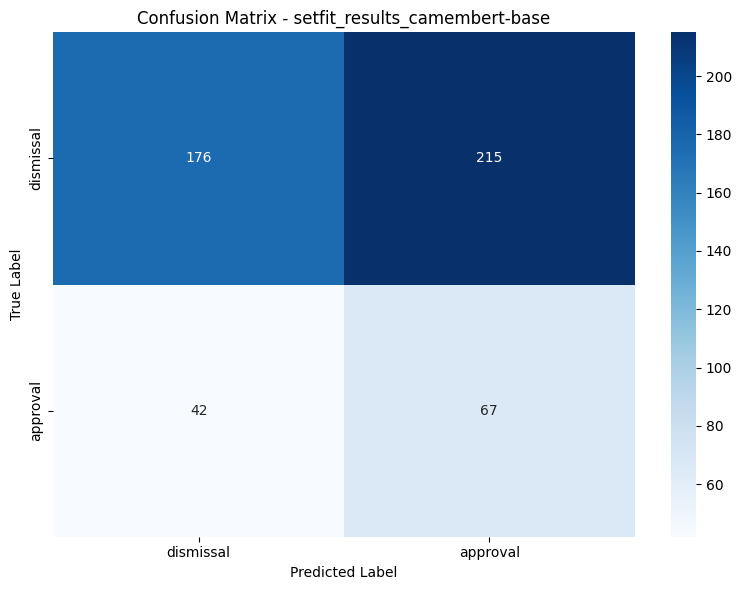

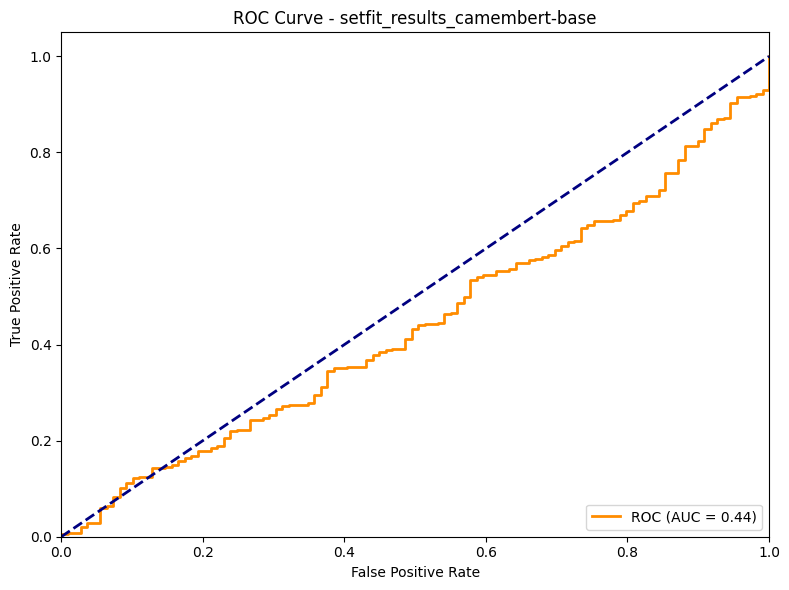

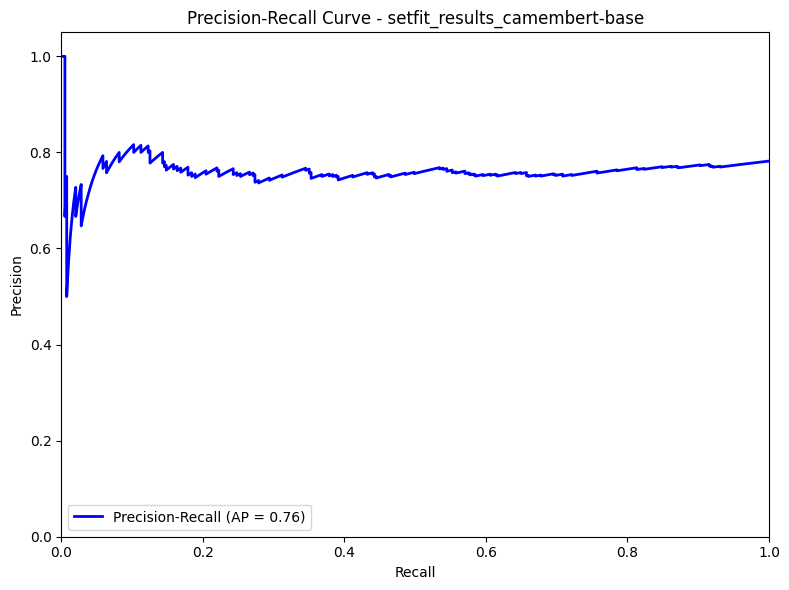

In [16]:
# Evaluate CamemBERT model
model_path = os.path.join('models', 'part_2', 'a', 'setfit_best_camembert-base')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename="setfit_results_camembert-base",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

Model loaded from: models/part_2/a/setfit_best_juribert-base
Making predictions on test set...

First 10 true and predicted labels:
True labels: ['dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'approval', 'dismissal']
Predicted labels: ['dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal', 'dismissal', 'dismissal', 'approval', 'dismissal', 'dismissal']
Predicted probabilities: [0.0007851355832424193, 0.0027032766031455176, 0.8364745607891187, 0.001584487507313795, 0.04609067038174123, 0.008428140010002723, 0.3586430690073332, 0.9829228549889099, 0.0008136889563317162, 0.0016749083397561162] 

              precision    recall  f1-score   support

   dismissal       0.77      0.62      0.69       391
    approval       0.20      0.35      0.26       109

    accuracy                           0.56       500
   macro avg       0.49      0.49      0.47       500
weighted avg       0.65      0.56      0.60       500



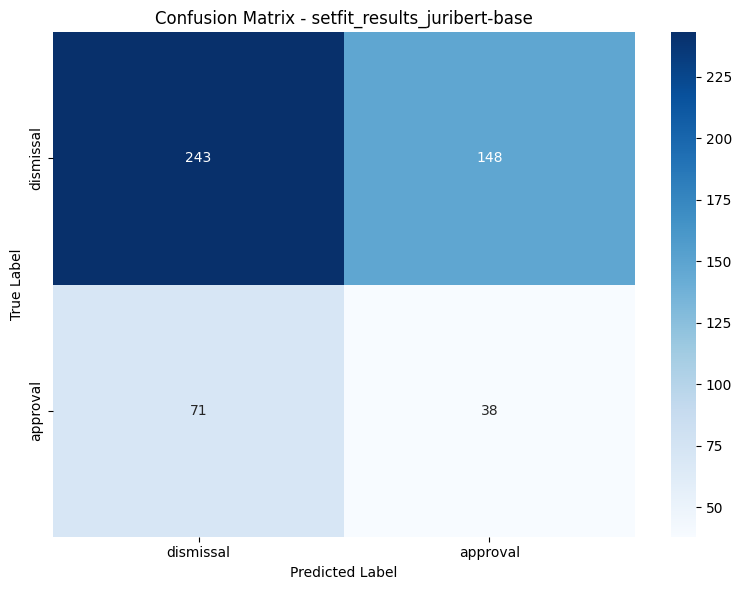

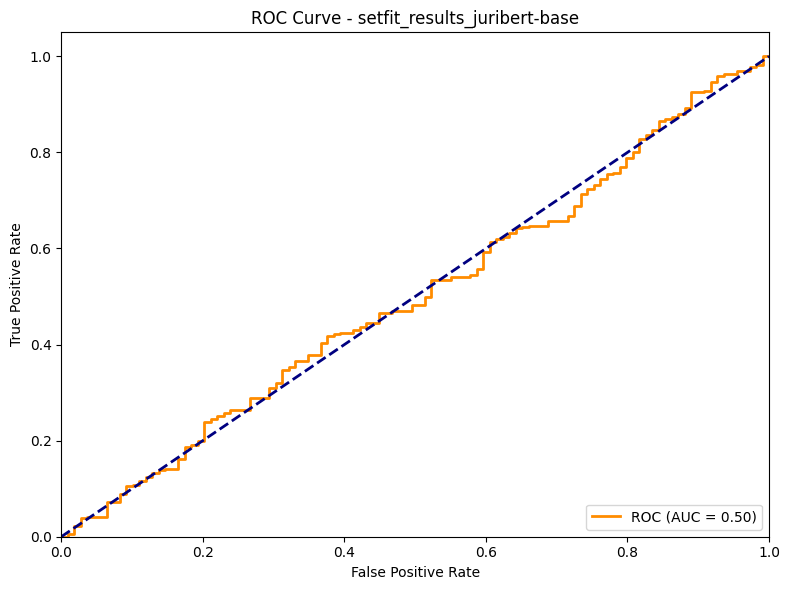

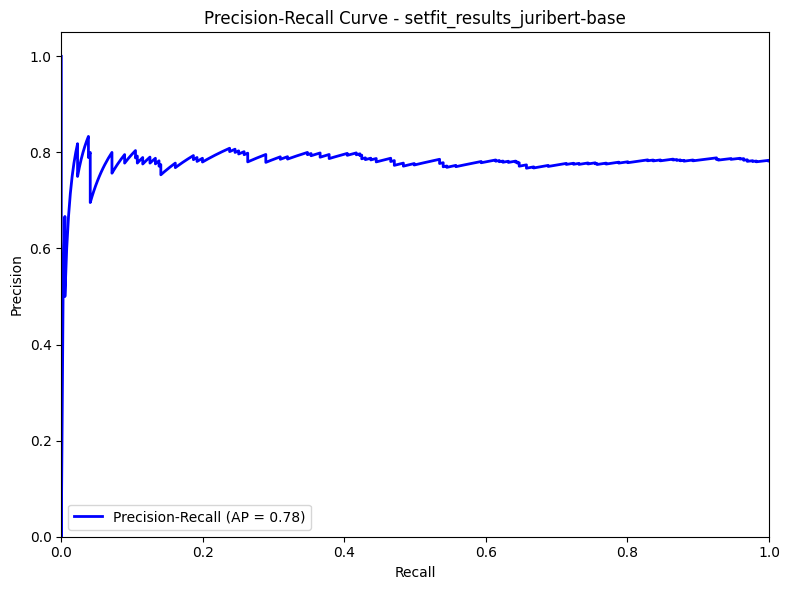

In [17]:
# Evaluate JuriBERT model
model_path = os.path.join('models', 'part_2', 'a', 'setfit_best_juribert-base')

y_test_true, y_test_pred_labels, y_test_pred_probas = evaluate_setfit_on_test(
    model_path=model_path, 
    test_df=test_df_fr, 
    sample_size=500,  # Sample size for the test set (optional, can be adjusted)
    seed=seed
)

# Convert integer labels to string labels for better readability
y_test_true_str = [labels_map[label] for label in y_test_true]
y_test_pred_str = [labels_map[label] for label in y_test_pred_labels]

print("\nFirst 10 true and predicted labels:")
print("True labels:", y_test_true_str[:10])  # Display first 10 true labels
print("Predicted labels:", y_test_pred_str[:10])  # Display first 10 predicted labels
print("Predicted probabilities:", y_test_pred_probas[:10].tolist(), '\n')  # Display first 10 predicted probabilities

# Make evaluation with different metrics
setfit_test_results = evaluate_classification(
    y_true=y_test_true_str,
    y_pred=y_test_pred_str,
    base_filename="setfit_results_juribert-base",
    labels=candidate_labels,
    probas=y_test_pred_probas,
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

### Models with standard fine-tuning

Loading model from: models/part_2/a/cls_fine_tuning_camembert-base/checkpoint-10
Loading tokenizer from: almanach/camembert-base
Sampling 500 rows from the test set...


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Making predictions on the test set...



Evaluating fine-tuned almanach/camembert-base on the test set:
              precision    recall  f1-score   support

   dismissal       0.78      0.74      0.76       391
    approval       0.20      0.24      0.22       109

    accuracy                           0.63       500
   macro avg       0.49      0.49      0.49       500
weighted avg       0.65      0.63      0.64       500



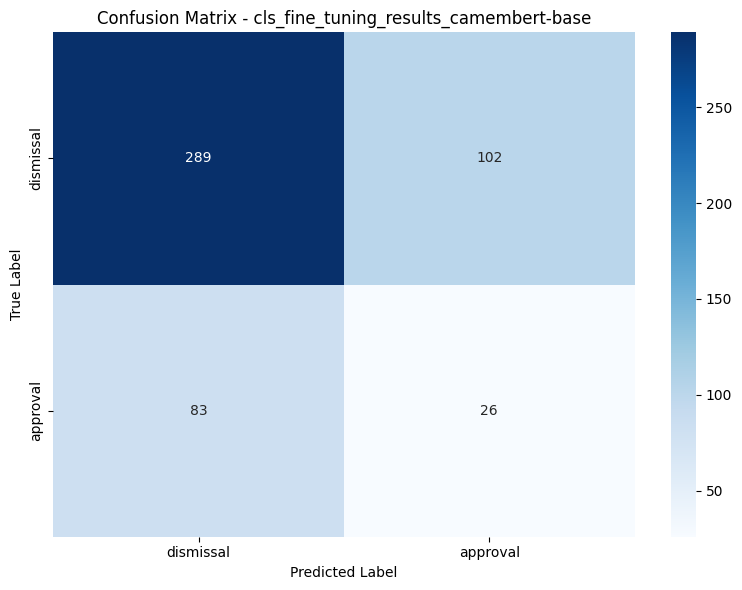

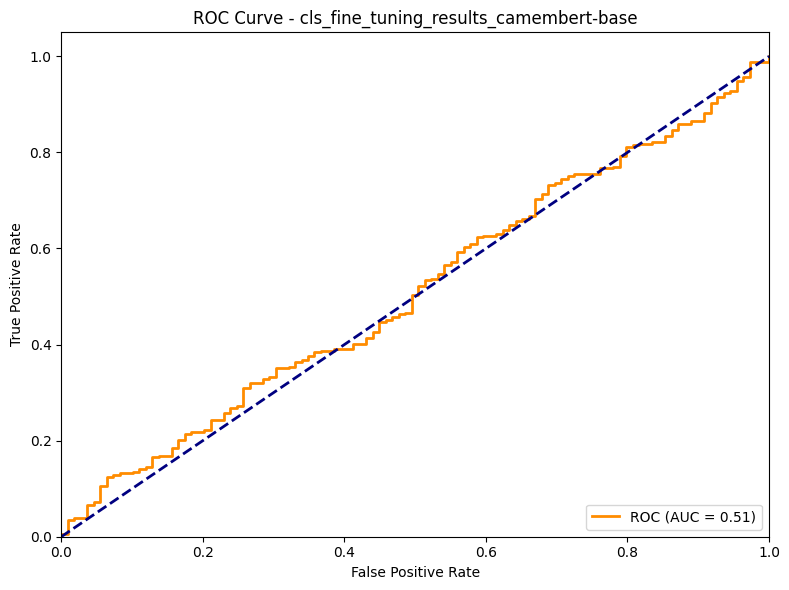

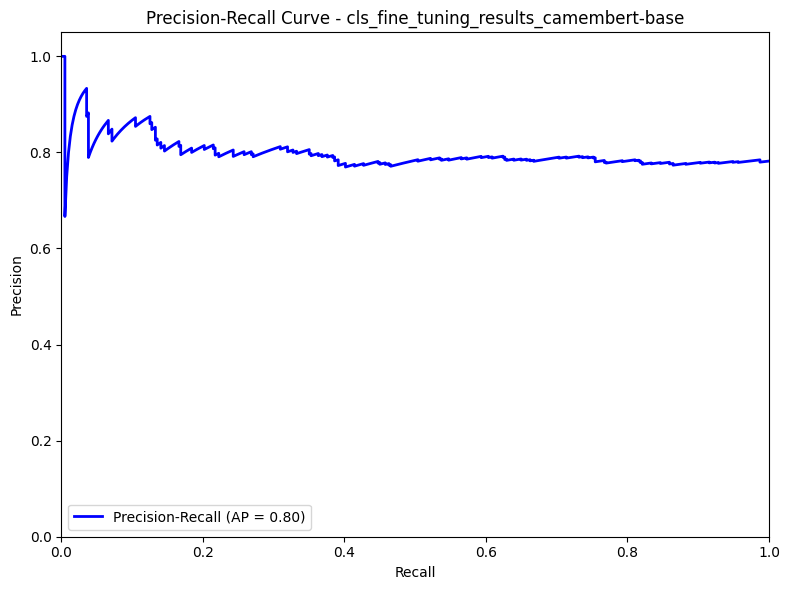

In [ ]:
# Evaluate the best fine-tuned model with CamemBERT
max_length = 512  # Maximum length used in training (can be adjusted based on the model)
model_name = "almanach/camembert-base"  # Original model name for tokenizer
sample_size = 500  # Sample size for the test set (optional, can be adjusted)

# First, we determine the best checkpoint directory based on the training results
# (see above)
checkpoint = 10
best_checkpoint_directory = os.path.join('models', 'part_2', 'a', 'cls_fine_tuning_juribert-base', f'checkpoint-{checkpoint}')

# Ensure test_df_fr has 'labels' column, not 'label'
if 'label' in test_df_fr.columns and 'labels' not in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'label': 'labels'})
    
y_true_test, y_pred_test, ft_probas = evaluate_best_finetuned_model(
    test_df=test_df_fr, # Your Polars test DataFrame
    model_checkpoint_path=best_checkpoint_directory, # Path to the best checkpoint
    original_model_name=model_name, # Original model name for tokenizer
    max_length=max_length, # Max length used in training
    sample_size=sample_size, # Sample size for the test set (optional, can be adjusted)
    seed=seed  # Random seed for reproducibility
)

y_true_test_str = [labels_map[label] for label in y_true_test] # Ensure lengths match if test_df_fr_eval was sampled
y_pred_test_str = [labels_map[label] for label in y_pred_test]

print(f"\nEvaluating fine-tuned {model_name} on the test set:")
finetuned_results = evaluate_classification(
    y_true=y_true_test_str,
    y_pred=y_pred_test_str,
    base_filename=f"cls_fine_tuning_results_camembert-base",
    labels=candidate_labels,
    probas=ft_probas, # Probabilities for the positive class
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

Loading model from: models/part_2/a/cls_fine_tuning_juribert-base/checkpoint-4
Loading tokenizer from: dascim/juribert-base
Sampling 500 rows from the test set...


/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-YMIcxN07-py3.12/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Making predictions on the test set...



Evaluating fine-tuned dascim/juribert-base on the test set:
              precision    recall  f1-score   support

   dismissal       0.80      0.80      0.80       391
    approval       0.27      0.27      0.27       109

    accuracy                           0.68       500
   macro avg       0.53      0.53      0.53       500
weighted avg       0.68      0.68      0.68       500



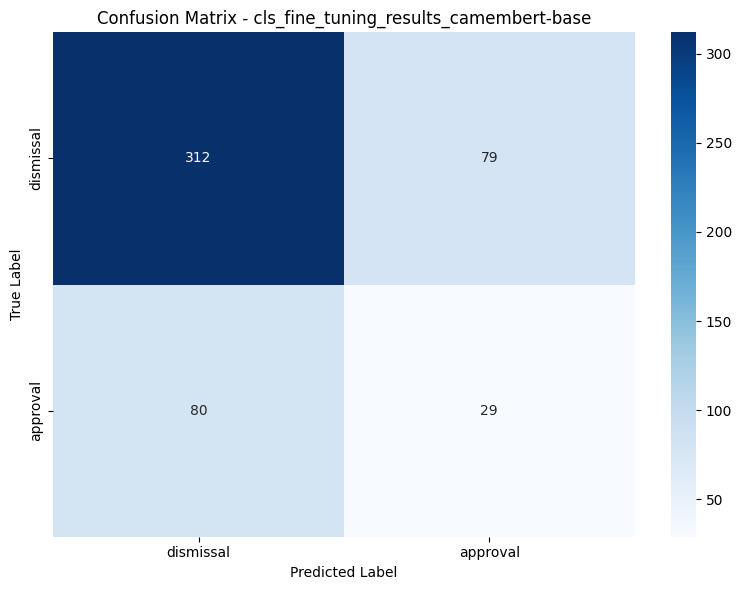

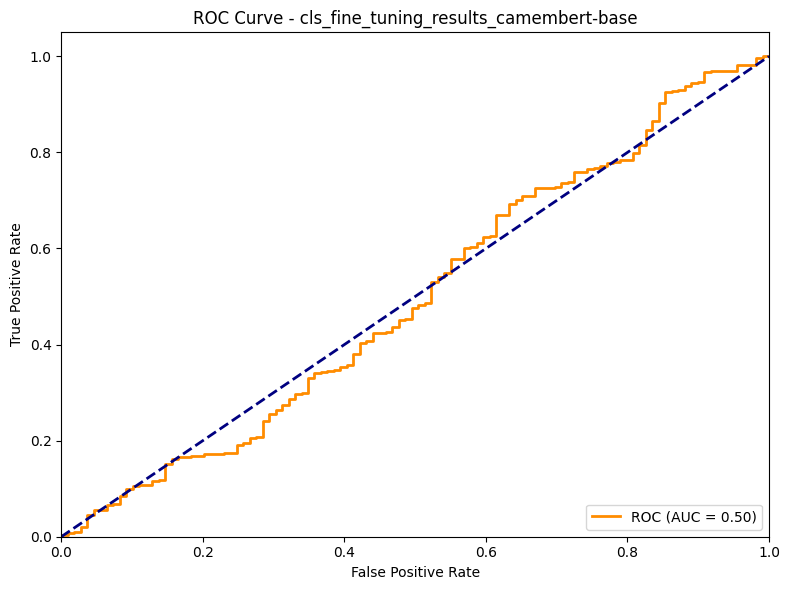

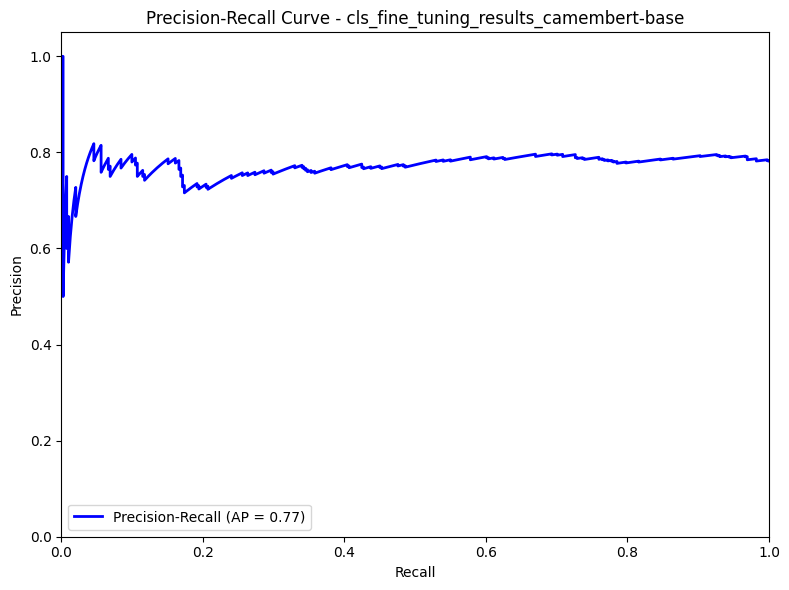

In [10]:
# Evaluate the best fine-tuned model with CamemBERT
max_length = 512  # Maximum length used in training (can be adjusted based on the model)
model_name = "dascim/juribert-base"  # Original model name for tokenizer
sample_size = 500  # Sample size for the test set (optional, can be adjusted)

# First, we determine the best checkpoint directory based on the training results
# (see above)
checkpoint = 4
best_checkpoint_directory = os.path.join('models', 'part_2', 'a', 'cls_fine_tuning_juribert-base', f'checkpoint-{checkpoint}')

# Ensure test_df_fr has 'labels' column, not 'label'
if 'label' in test_df_fr.columns and 'labels' not in test_df_fr.columns:
    test_df_fr = test_df_fr.rename({'label': 'labels'})
    
y_true_test, y_pred_test, ft_probas = evaluate_best_finetuned_model(
    test_df=test_df_fr, # Your Polars test DataFrame
    model_checkpoint_path=best_checkpoint_directory, # Path to the best checkpoint
    original_model_name=model_name, # Original model name for tokenizer
    max_length=max_length, # Max length used in training
    sample_size=sample_size, # Sample size for the test set (optional, can be adjusted)
    seed=seed  # Random seed for reproducibility
)

y_true_test_str = [labels_map[label] for label in y_true_test] # Ensure lengths match if test_df_fr_eval was sampled
y_pred_test_str = [labels_map[label] for label in y_pred_test]

print(f"\nEvaluating fine-tuned {model_name} on the test set:")
finetuned_results = evaluate_classification(
    y_true=y_true_test_str,
    y_pred=y_pred_test_str,
    base_filename=f"cls_fine_tuning_results_camembert-base",
    labels=candidate_labels,
    probas=ft_probas, # Probabilities for the positive class
    results_dir=os.path.join('results', 'part_2', 'a', 'test')
)

## 1.4. Conclusions

# 2. Dataset Augmentation

Outline of the intermediate tasks: We want a fully automated pipeline. A good candidate is Easy Data Augmentation (EDA) or back-translation via open‐source MT models.
1. Choose Technique(s)
   - Easy Data Augmentation techniques (random insertion, deletion, swap).
   - Random synonym substitution (WordNet or fastText).
   - Back-translation: FR → EN → FR using MarianMT or opus-MT.
2. Implement & Generate
   - For each of the 32 labeled examples, generate k augmented pseudo-examples (e.g. k=5).
   - Deduplicate and filter (e.g. reject if new text <50% overlap).
3. Merge & Re-split
   - Combine original 32 + synthetic N = 32×k examples.
   - Re-run the same CV split strategy, ensuring augmented copies of a given original stay in the same fold.
4. Re-train BERT
   - Exactly the same hyperparams as in (a).
   - Track performance uplift vs. the baseline.
5. Analysis
   - Compare metrics: ΔAccuracy, ΔF1.
   - Ablation: EDA vs. back-translation vs. combined.
   - Qualitative: inspect a few synthetic samples.

# 3. Zero-Shot Learning with LLM

We will try several models for ZSL exercise. Our API access comes from groq.com, which has a wide variety of LLMs. The process is quite slow, and since the model runs on Groq’s servers, we cannot move inference to our local CUDA GPU.

In [26]:
df_approval = test_df.filter(pl.col('labels') == 1)

In [ ]:
import json

with open('config_files\llm_config.json') as f:
    config = json.load(f)

### DeepSeek 90b model

In [35]:
import os
from groq import Groq
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

groq_api_key = os.getenv("GROQ_API_KEY")
client = Groq(api_key=groq_api_key)

In [36]:
from library.llms import classify_case

In [ ]:
import time
import tqdm

def process_batch(df_approval, batch_size=10):
    y_pred, y_true = [], []
    for i in range(0, len(df_approval), batch_size):
        batch = df_approval.slice(i, min(batch_size, len(df_approval) - i))
        for case in tqdm.tqdm(batch.iter_rows(named=True)):
            y_true.append(case['label'])
            y_pred.append(classify_case(case['text']))
            time.sleep(config.get("processing_settings", {}).get("delay_between_requests", 0))
    return y_true, y_pred

# Sample a subset of the test data to evaluate
test_sample = df_approval.sample(10, seed=seed)
if 'labels' in test_sample.columns:
    test_sample = test_sample.rename({'labels': 'label'})

# Run prediction
y_true, y_pred = process_batch(test_sample, batch_size=config.get("processing_settings", {}).get("batch_size", 10))

6it [01:24, 16.41s/it]

Metrics calculated for: zero_shot_llm

Metrics for zero_shot_llm

Accuracy: 0.00%

Precision: 0.00%

Recall: 0.00%

F1 Score: 0.00%


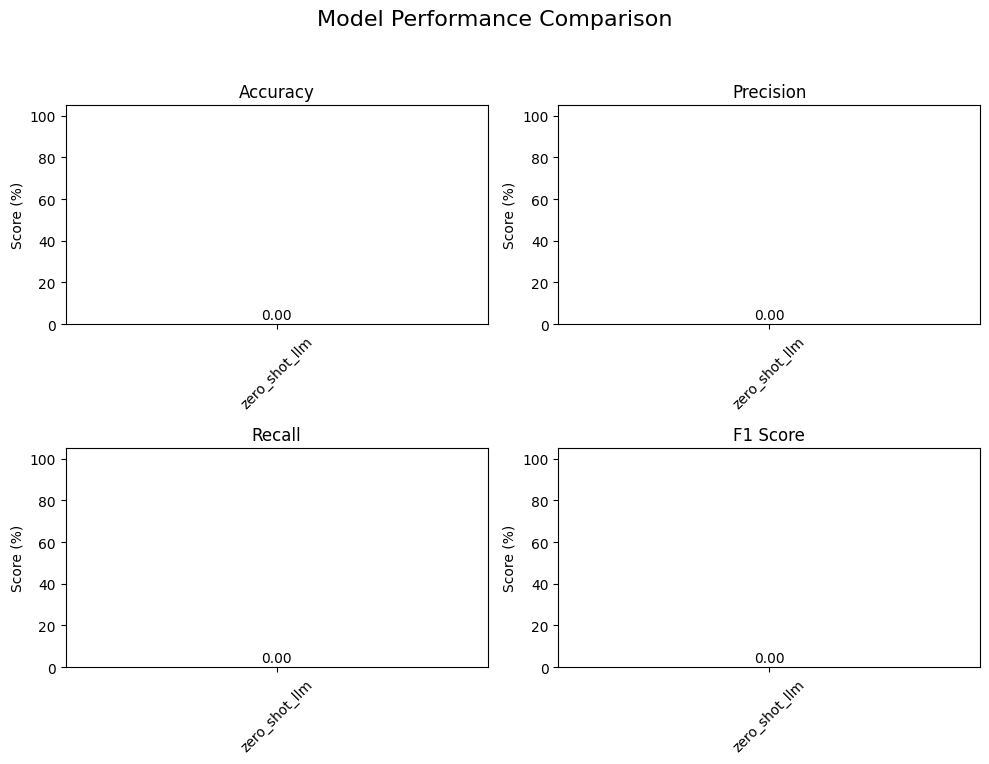

In [28]:
# Calculate and display metrics
metrics.run(y_true, y_pred, 'zero_shot_llm', average='binary')
metrics.print_results()
metrics.plot()

### Mixtral-8x7b-32768

In [ ]:
# Change model without touching code
config["model_settings"]["model_name"] = "mixtral-8x7b-32768"

# processing parameters
config["processing_settings"]["batch_size"] = 5
config["processing_settings"]["delay_between_requests"] = 1.0

# 4. Data Generation with LLM

# 5. Optimal Technique Application